#### Conditional Tb on the CAPE-SUBSAT diagram

In [15]:
import os
import sys
import xarray as xr
import numpy as np
from numpy import unravel_index
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.font_manager import FontProperties
from datetime import datetime
from pathlib import Path
import warnings

In [16]:
warnings.filterwarnings('ignore')

In [111]:
%%time
year_list = np.arange(2001,2021)
BL_bins = np.arange(-30,10,0.2) # [K]

data_BLclim = xr.open_dataset('/scratch/wmtsai/temp_mcs/output_stats/era5_BL_measures_climatology_2002-2014.nc')

for n,year in enumerate(year_list[:1]):

    buoy_dir = Path('/scratch/wmtsai/featenv_analysis/dataset/MCS_FLEXTRKR_tropics/{}/environment_catalogs/VARS_derived'.format(year))        
    mask_dir = Path('/scratch/wmtsai/featenv_analysis/dataset/MCS_FLEXTRKR_tropics/{}/environment_catalogs/VARS_2D'.format(year))        

    data_buoy = xr.open_dataset(buoy_dir / 'MCS_FLEXTRKR_tropics_buoyancy.30NS.nc')
    data_mask = xr.open_dataset(mask_dir / 'MCS_FLEXTRKR_tropics_cloudtracknumber_nomergesplit.merged.nc')
    track_stats = xr.open_dataset('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/mcs_tracks_non2mcs_{}.tropics30NS.full.nc'.format(year))

    buoy_deviate_all = np.zeros((len(track_stats.tracks), 6, 3)) # (tracks, mcs_phases, 3 BL components)
    for t,track in enumerate(data.tracks.values):
        buoy_track = data_buoy.sel(tracks=track)
        mask_track = data_mask.sel(tracks=track)
        # create datetimes for MCS life stages:
        time_sel = [ track_stats.sel(tracks=track).idt_ccs_init,
                     track_stats.sel(tracks=track).idt_mcs_init,
                     track_stats.sel(tracks=track).idt_mcs_grow,
                     track_stats.sel(tracks=track).idt_mcs_mature,
                     track_stats.sel(tracks=track).idt_mcs_decay,
                     track_stats.sel(tracks=track).idt_mcs_end]
        # retrun datetime by the given index
        datetime_sel = track_stats.base_time.sel(times=time_sel, tracks=track)

        for n,time_info in enumerate(datetime_sel):
            
            mcsmask = mask_track.cloudtracknumber_nomergesplit.isel(time=0)
            
            BL_tot_phase = buoy_track.Buoy_TOT.isel(time=n)
            BL_tot_phase = BL_tot_phase.where(mcsmask > 0)

            BL_cape_phase = buoy_track.Buoy_CAPE.isel(time=n)
            BL_cape_phase = BL_cape_phase.where(mcsmask > 0)

            BL_subsat_phase = buoy_track.Buoy_SUBSAT.isel(time=n)
            BL_subsat_phase = BL_subsat_phase.where(mcsmask > 0)

            meanlon = buoy_track.isel(time=n).meanlon
            meanlat = buoy_track.isel(time=n).meanlat
            month_info = int(str(time_info.values)[5:7])
            BL_clim_amean = data_BLclim.sel(month=month_info,
                                            lat=slice(meanlat-3,meanlat+3), lon=slice(meanlon-3,meanlon+3)).mean()
            BL_tot_amean = BL_clim_amean.Buoy_TOT
            BL_cape_amean = BL_clim_amean.Buoy_CAPE
            BL_subsat_amean = BL_clim_amean.Buoy_SUBSAT 

            # calculate deviation from climatology
            BL_tot_deviate = BL_tot_phase.mean(('x','y')) - BL_tot_amean
            BL_cape_deviate = BL_cape_phase.mean(('x','y')) - BL_cape_amean
            BL_subsat_deviate = BL_subsat_phase.mean(('x','y')) - BL_cape_amean

            buoy_deviate_all[t,n,:] = [BL_tot_deviate.values, BL_cape_deviate.values, BL_subsat_deviate.values]

# saveinto dataset
ds_buoy_deviate = xr.Dataset(data_vars = dict( Buoy_TOT_deviate = (['tracks','mcs_phase'], buoy_deviate_all[:,:,0]),
                                               Buoy_CAPE_deviate = (['tracks','mcs_phase'], buoy_deviate_all[:,:,1]),
                                               Buoy_SUBSAT_deviate = (['tracks','mcs_phase'], buoy_deviate_all[:,:,2])),
                             coords = dict( tracks = (['tracks'], track_stats.tracks.values),
                                            mcs_phase = (['mcs_phase'], ['ccs','init','grow','mature','decay','end'])),
                             attrs = dict( description = 'Deviation from the climatological monthly mean')
                            )

CPU times: user 4min 13s, sys: 2.49 s, total: 4min 15s
Wall time: 4min 17s


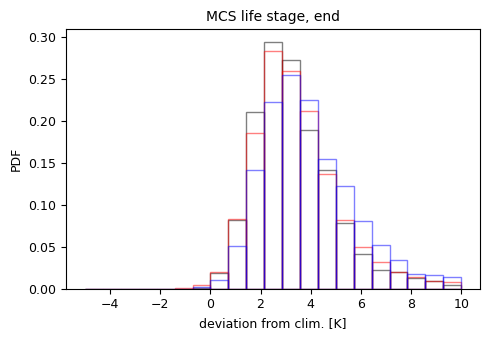

In [128]:
fig,ax = plt.subplots(1,1,figsize=(5,3.5))
for ax,mcs_phase,color in zip([ax,ax,ax], ['init','mature','end'], ['k','r','b']):
    ax.hist(ds_buoy_deviate.sel(mcs_phase=mcs_phase).Buoy_SUBSAT_deviate*(340*3/9.81), range=(-5,10), bins=21, density=True
                , edgecolor=color, facecolor='none', alpha=0.5)
    # adding mean and Q1Q3 range
    ax.tick_params(labelsize=9)
    ax.set_xlabel('deviation from clim. [K]',fontsize=9)
    ax.set_ylabel('PDF',fontsize=9)
    ax.set_title('MCS life stage, {}'.format(mcs_phase),fontsize=10)
    #ax.set_ylim([0,0.8])
plt.tight_layout()
plt.show()

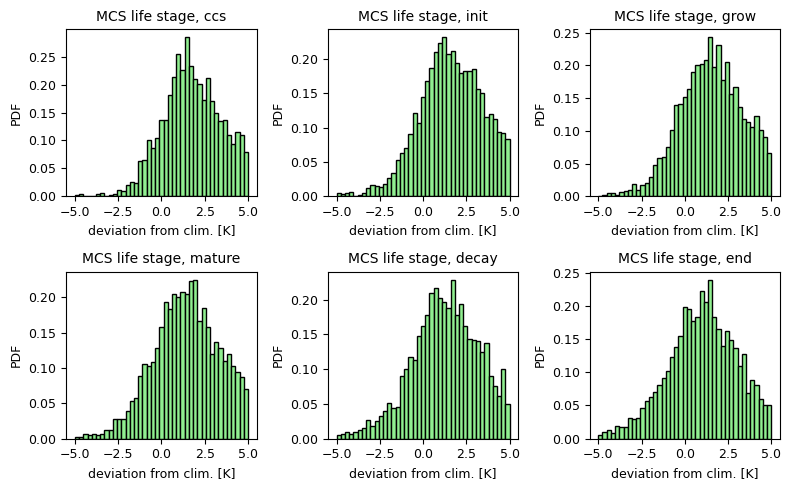

In [119]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(8,5))
for ax,mcs_phase in zip([ax1,ax2,ax3,ax4,ax5,ax6], ds_buoy_deviate.mcs_phase.values):
    ax.hist(ds_buoy_deviate.sel(mcs_phase=mcs_phase).Buoy_TOT_deviate*(340*3/9.81), range=(-5,5), bins=41, density=True
                , edgecolor='k', facecolor='lightgreen')
    # adding mean and Q1Q3 range
    ax.tick_params(labelsize=9)
    ax.set_xlabel('deviation from clim. [K]',fontsize=9)
    ax.set_ylabel('PDF',fontsize=9)
    ax.set_title('MCS life stage, {}'.format(mcs_phase),fontsize=10)
    #ax.set_ylim([0,0.8])
plt.tight_layout()
plt.show()

In [76]:
#test = xr.open_dataset('/scratch/wmtsai/temp_mcs/output_stats/era5_BL_measures_climatology_2002-2014.nc')
test = xr.open_dataset('/scratch/wmtsai/temp_mcs/output_stats/BLmap_clim.test.nc')

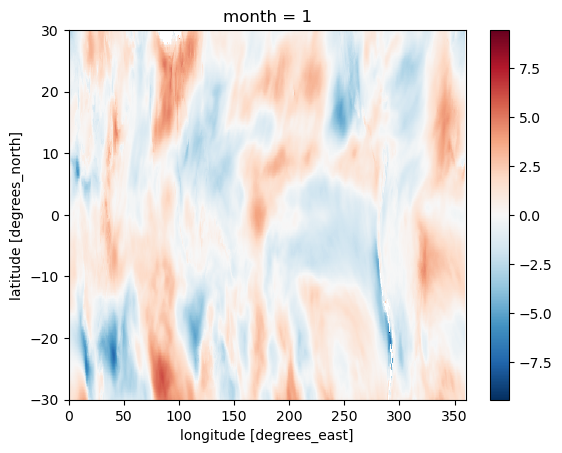

In [86]:
(test.sel(month=1).Buoy_TOT_mavg - (340*3/9.8)*data_BLclim.sel(month=1).Buoy_TOT).plot() 

In [ ]:
#### contribution of total rainfall 

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(6,4))

bins_cape = tb_sum_oce.bins_cape
bins_subsat = tb_sum_oce.bins_subsat

dbl = 0.25
tb_sum = tb_sum_oce.interp(bins_cape=np.arange(bins_cape[0],bins_cape[-1]+dbl,dbl),
                                           bins_subsat=np.arange(bins_subsat[0],bins_subsat[-1]+dbl,dbl))
samples_all = samples_all_oce.interp(bins_cape=np.arange(bins_cape[0],bins_cape[-1]+dbl,dbl),
                                           bins_subsat=np.arange(bins_subsat[0],bins_subsat[-1]+dbl,dbl))

# total samples and rain rate in all phases
samples_allphases = samples_all_oce.sel(area_type='mcs',phase=['Initial','End','Grow','Mature','Decay']).sum(('duration_type','phase'))
total_tb = tb_sum.sel(area_type='mcs',phase=['Initial','End','Grow','Mature','Decay']).sum(('duration_type','phase'))

for p,(ax,phase,label_str) in enumerate(zip([ax1,ax3,ax4,ax5,ax6],['Initial','End','Grow','Mature','Decay'],
                                            ['(a)','(b)','(c)','(d)','(e)'])):
    
    var_sum = tb_sum_oce.sel(area_type='mcs', phase=phase).sum('duration_type')
    tmp = samples_all_oce.sel(area_type='mcs', phase=phase).sum('duration_type')
    tmp = tmp.where(tmp > 200)
    
    # conditional mean of gpm precip (mm/hr)
    cp = ax.contourf(tmp.bins_subsat, tmp.bins_cape, var_sum/tmp, cmap='binary_r',
                     levels=np.arange(220,242.5,2.5),zorder=2, extend='min')
    cs = ax.contour(tmp.bins_subsat, tmp.bins_cape, var_sum/tmp, colors='k',linewidths=0.5,
                     levels=[220,225,230,235,240],zorder=2)
    ax.clabel(cs, inline=False, fontsize=6)

    if phase == 'End':
        cbaxes = fig.add_axes([0.985, 0.3, 0.01, 0.4])              
        cbar = plt.colorbar(cp, cax=cbaxes, shrink=0.7)
        cbar.set_label('(K)') 
        
    # add buoyancy reference 
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-4, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-6, color='grey', ls='--',lw=0.5)
    
    ## configuration of tick, labels
    ax.text(-1.2,4.3,'{}'.format(phase),fontsize=9,color='k')
    ax.grid(ls=':', lw=0.5, zorder=1)
    ax.set_xticks([-2,0,2,4,6,8,10,12])
    ax.set_yticks([-8,-6,-4,-2,0,2,4])
    ax.tick_params(labelsize=9)
    ax.tick_params('both', length=0, width=1, which='major')
    
    # set x-y domain 
    ax.set_ylim([-8,6])
    ax.set_xlim([-2,14])  
    
ax2.tick_params('both', length=0, width=1, which='major')
    
ax1.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax5.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax6.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])

#====== schematic part for axis 2 =======
# add buoyancy reference 
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1)
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2, color='grey', ls='--',lw=0.5)
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-4, color='grey', ls='--',lw=0.5)
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-6, color='grey', ls='--',lw=0.5)

(idx,idy) = unravel_index(samples_allphases.argmax(), samples_allphases.shape)
cape_mode = samples_allphases.bins_cape[idx]
subsat_mode = samples_allphases.bins_subsat[idy] 
ax2.plot(subsat_mode, cape_mode, 's', ms=4, color='grey')

ax2.set_ylim([-8,6])
ax2.set_xlim([-2,14])

plt.suptitle('Conditional Tb, MCS grids, All \n N. of samples min = 200.', x=0.54, y=0.94, fontsize=9.5, fontweight='bold')
plt.tight_layout(h_pad=0.4,w_pad=0.01)

plt.show()

#fig.savefig('/scratch/wmtsai/temp_mcs/fig/BL2Dhist_CondPrec_allsurface.rotate.pdf',
#    bbox_inches='tight',transparent=False)